In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso

plt.rcParams['figure.figsize'] = (8,5)

RANDOM_STATE = 42
df = pd.read_csv("students_performance.csv")

## Introduction
In this notebook, we will perform a regression analysis on the Student Performance dataset.
Our goal is to understand how different factors such as study hours, previous scores, sleep time, and extracurricular activities influence students’ overall performance and train various regression models to predict student scores and evaluate their effectiveness.

## Data source:
https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression

## We will:
* explore and visualize the dataset,
* preprocess the data using scaling and encoding inside a pipeline,
* train several regression models: Linear Regression, Ridge, Lasso, and ElasticNet,
* use cross-validation to compare their performance,
* analyze model coefficients and residuals to draw conclusions.

In [26]:
print("Shape:", df.shape)
display(df.head(10))

Shape: (10000, 6)


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
5,3,78,No,9,6,61.0
6,7,73,Yes,5,6,63.0
7,8,45,Yes,4,6,42.0
8,5,77,No,8,2,61.0
9,4,89,No,4,0,69.0


The dataset contains 10,000 observations and 6 variables.
Each row represents a student with information about study habits, previous performance, and lifestyle factors.
The data looks clean and well structured, so we can proceed to check data types, missing values, and summary statistics.

In [27]:
# Checking data types, missing values, and basic statistics
display(df.info())

# Check for missing values
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:")
display(missing[missing > 0] if (missing > 0).any() else "No missing values found.")

# Summary statistics for all columns
display(df.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


None

Missing values per column:


'No missing values found.'

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,No,NaN,NaN,NaN
freq,NaN,NaN,5052,NaN,NaN,NaN
mean,4.992900,69.445700,NaN,6.530600,4.583300,55.224800
std,2.589309,17.343152,NaN,1.695863,2.867348,19.212558
min,1.000000,40.000000,NaN,4.000000,0.000000,10.000000
25%,3.000000,54.000000,NaN,5.000000,2.000000,40.000000
50%,5.000000,69.000000,NaN,7.000000,5.000000,55.000000
75%,7.000000,85.000000,NaN,8.000000,7.000000,71.000000


There are no missing values, and all columns have appropriate data types.
The target variable Performance Index ranges from 10 to 100, which suggests it is measured on a percentage-like scale.
The dataset includes both numerical and categorical features, which means we will need to handle encoding and scaling in our preprocessing pipeline later.

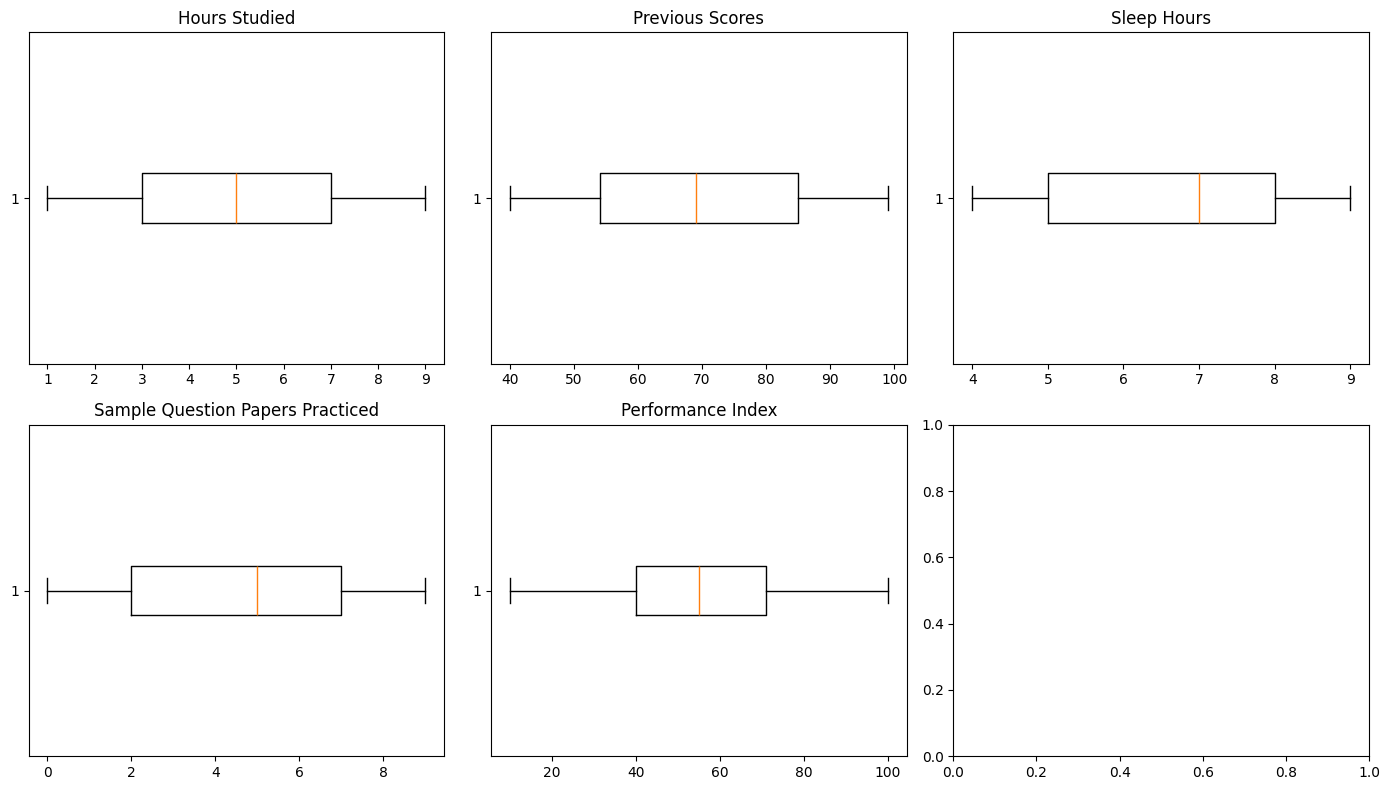

In [28]:
# Checking distributions and potential outliers
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Plot boxplots for all numerical features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].boxplot(df[col], vert=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

The boxplots show that the numerical features are well distributed and do not contain significant outliers.
Most variables have compact ranges, and their scales are relatively consistent (for example, between 0–10 or 0–100).
Even though scaling is not strictly necessary, we will still include it in the preprocessing pipeline to ensure that all features contribute equally to the regularized models (Ridge, Lasso, ElasticNet), which are sensitive to feature scale.

The dataset is clean, well-structured, and free of missing values or strong outliers.
All numerical features are within reasonable ranges, and their scales are relatively consistent.
We can now move on to building a preprocessing pipeline and training regression models.

In [29]:
# Baseline Linear Regression

# Fixed target (we know its name)
TARGET_COLUMN = "Performance Index"

# Split features/target
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# Identify feature types
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

# Minimal preprocessing: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ],
    remainder="drop"
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Linear model in a pipeline
lin_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
y_pred = lin_pipe.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"Baseline Linear (TEST) -> MSE: {mse:.4f} | R2: {r2:.4f}")


Baseline Linear (TEST) -> MSE: 4.0826 | R2: 0.9890


## Goal of this cell.
We build a minimal but correct baseline for regression:
* split the data into features X and target y,
* apply proper preprocessing (scale numeric features and one-hot encode categorical ones) inside the modeling pipeline,
* train a plain Linear Regression on a hold-out test split, and
* report simple metrics (MSE, R²) as a reference point for later model comparison.
## Why scaling (even if the ranges look “reasonable”)?
Linear Regression itself doesn’t require scaling to produce predictions, but we will compare it with regularized models (Ridge, Lasso, ElasticNet) next. Regularization penalties depend on the magnitude of coefficients, which in turn depends on the scale of features. Without scaling, features with larger numeric ranges would be penalized differently, biasing the comparison. We therefore apply RobustScaler to numeric features. Unlike StandardScaler, it uses the median and IQR, so it is more stable if hidden outliers exist (boxplots suggested there aren’t strong outliers, but RobustScaler is a safe default).
Scaling ensures fair, comparable regularization across features and makes later Ridge/Lasso/ElasticNet results trustworthy.
## How we treat categorical variables?
We encode the categorical column(s) (e.g., Extracurricular Activities: Yes/No) via OneHotEncoder. This turns categories into binary indicator columns (0/1).
We use handle_unknown="ignore" so that if a new category appears in test data (or in another split), the pipeline won’t crash; it simply ignores unseen levels.
## What ColumnTransformer and Pipeline add (wasn’t in the primary notebook)?
ColumnTransformer lets us route different preprocessing to different column types in one object:
numeric → RobustScaler
categorical → OneHotEncoder
Pipeline then chains preprocessing (prep) with the estimator (LinearRegression). This guarantees that preprocessing is fit only on the training data and applied consistently to both train and test. Two crucial benefit:
* fitting — is repeated correctly within each fold).
## Why we split and train a first model now (before cross-validation)?
A single train/test baseline is a fast, interpretable starting point. It answers: “If we do the simplest reasonable thing, how well do we do?”
This result is not our final judgement — cross-validation will give a more robust estimate (averaged across folds). But having this baseline helps us quantify improvements once we add regularization and CV.
## Interpreting the result:
Baseline Linear (TEST) -> MSE: 4.0826 | R2: 0.9890
* R² = 0.9890 is very high, meaning the linear model explains ~98.9% of the variance in the target. For a target that ranges roughly from 10 to 100, this indicates a strong linear relationship between features and the performance index.
* MSE = 4.0826 implies an average squared error of ~4.08.

### These numbers suggest that a simple linear model already performs very well on this dataset. That said, a single train/test split can still be slightly optimistic or pessimistic depending on the random split; k-fold cross-validation (next step) will confirm whether performance is consistently strong across different folds.

## What’s next?
We will run k-fold cross-validation for Linear, Ridge, Lasso, and ElasticNet, all using the same preprocessing pipeline, and compare MSE and R². This will validate the baseline, show whether regularization helps, and provide a fair model selection procedure.

In [30]:
# Cross-validation comparison: Linear, Ridge, Lasso, ElasticNet
alphas = np.logspace(-3, 3, 50)
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Define models using the same preprocessing
pipelines = {
    "Linear": Pipeline([("prep", preprocessor), ("model", LinearRegression())]),
    "RidgeCV": Pipeline([("prep", preprocessor), ("model", RidgeCV(alphas=alphas, cv=5))]),
    "LassoCV": Pipeline([("prep", preprocessor), ("model", LassoCV(alphas=alphas, cv=5, max_iter=20000))]),
    "ElasticNetCV": Pipeline([("prep", preprocessor), ("model", ElasticNetCV(alphas=alphas, l1_ratio=[.1,.5,.7,.9,.95,1.0], cv=5, max_iter=20000))]),
}

# Evaluate each model using 5-fold CV
rows = []
for name, pipe in pipelines.items():
    res = cross_validate(
        pipe, X, y, cv=cv,
        scoring={"mse": "neg_mean_squared_error", "r2": "r2"},
        n_jobs=-1
    )
    mse_mean = -res["test_mse"].mean()
    mse_std  =  res["test_mse"].std()
    r2_mean  =  res["test_r2"].mean()
    r2_std   =  res["test_r2"].std()
    rows.append({
        "Model": name,
        "MSE_mean": mse_mean,
        "MSE_std": mse_std,
        "R2_mean": r2_mean,
        "R2_std": r2_std,
    })

cv_results = pd.DataFrame(rows).sort_values("MSE_mean").reset_index(drop=True)
display(cv_results)

,Model,MSE_mean,MSE_std,R2_mean,R2_std
0,Linear,4.157247,0.076883,0.988732,0.00019
1,RidgeCV,4.157253,0.076887,0.988732,0.00019
2,LassoCV,4.157260,0.076990,0.988732,0.00019
3,ElasticNetCV,4.157260,0.076990,0.988732,0.00019


## Goal of this step:
In this section we extend the baseline analysis by applying k-fold cross-validation to compare four regression models:
* Linear Regression,
* Ridge,
* Lasso,
* ElasticNet.

Each model uses the same preprocessing pipeline (scaling for numeric features, one-hot encoding for categorical ones).
This ensures a fair and consistent comparison — all models see identically transformed data.
## What cross-validation does (and why we use it)?
Cross-validation (CV) is a model evaluation technique used to estimate how well a model generalizes to unseen data.
We split the dataset into k parts (folds) — here, k = 5.
The model is trained on 4 folds and tested on the remaining one, repeating this process 5 times so that every observation appears in the test fold exactly once.
The reported metrics (MSE, R²) are averages across all folds, providing a more reliable and less random estimate than a single train/test split.
Using CV is especially important when comparing multiple models, because it makes sure that each model is evaluated on exactly the same folds, under identical conditions.
## What “alphas” represent (regularization strength)?
Regularization models (Ridge, Lasso, ElasticNet) include a parameter called α (alpha) which controls the penalty applied to large coefficients.
Larger α → stronger penalty → smaller coefficients → potentially less overfitting but higher bias.
Smaller α → weaker penalty → model behaves more like plain Linear Regression.
We define alphas = np.logspace(-3, 3, 50) to test 50 values evenly spaced on a logarithmic scale between
10^−3 and 10^3.
The logarithmic scale is used because α can vary across several orders of magnitude.
These bounds (−3, 3) are a good general-purpose range that covers very small to very strong regularization.
Each regularized model will automatically find the optimal α from this range through internal cross-validation (RidgeCV, LassoCV, ElasticNetCV).
## How the models differ conceptually?
* Linear Regression: minimizes the sum of squared errors without any penalty; all coefficients are estimated freely.
* Ridge Regression (L2 penalty): adds a penalty on the sum of squared coefficients. It shrinks coefficients toward zero but never exactly to zero. Useful when features are correlated.
* Lasso Regression (L1 penalty): penalizes the sum of absolute coefficients. It can shrink some coefficients exactly to zero — performing implicit feature selection.
* ElasticNet: combines both L1 and L2 penalties; it can balance between Ridge’s stability and Lasso’s sparsity using a parameter called l1_ratio.

The key idea behind all regularized models is to reduce overfitting and improve generalization by constraining how large the coefficients can grow.
## How we apply cross-validation here?
* We define four pipelines — one per model — all sharing the same preprocessing stage.
* We use cross_validate() with 5-fold CV to compute MSE and R² for each model.
* The results (mean and std) summarize both average accuracy and stability across folds.
* Models are then sorted by MSE to make it easier to spot which performs best.

## RESULTS:
The cross-validation results show that all four models — Linear, Ridge, Lasso, and ElasticNet - achieve almost identical performance (MSE ≈ 4.16, R² ≈ 0.989).
This indicates that the dataset has a strong linear structure and has no significant overfitting issues.

The regularized models (Ridge, Lasso, ElasticNet) do not improve over plain Linear Regression, meaning that the optimal regularization strength α is likely very small.
In practice, this suggests that the baseline Linear Regression is already optimal for this dataset.

The extremely low standard deviations (MSE_std ≈ 0.08, R²_std ≈ 0.0002) confirm that the model’s performance is highly stable across folds, and that cross-validation results are consistent and reliable.

Overall, these findings validate that our preprocessing and modeling approach is correct, and that the underlying relationship between study habits and performance index is effectively linear.

In [31]:
# Fit the final model on the full dataset
final_model = Pipeline([
    ("prep", preprocessor),
    ("model", LinearRegression())
])
final_model.fit(X, y)

# Get feature names after preprocessing
feature_names = (
    num_features +
    list(final_model.named_steps["prep"]
         .named_transformers_["cat"]
         .get_feature_names_out(cat_features))
)

# Extract coefficients
coefs = final_model.named_steps["model"].coef_
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)

display(coef_df)


,Feature,Coefficient
1,Previous Scores,31.569840
0,Hours Studied,11.411476
2,Sleep Hours,1.441617
3,Sample Question Papers Practiced,0.968985
5,Extracurricular Activities_Yes,0.306447
4,Extracurricular Activities_No,-0.306447


### The coefficient analysis confirms that the dataset exhibits a clear and strongly linear structure.

* The two dominant predictors are Previous Scores and Hours Studied, both showing large positive coefficients. This means that students who performed well in earlier tests and who spend more hours studying are predicted to achieve higher overall performance.

* Sleep Hours and Sample Question Papers Practiced also contribute positively but with smaller magnitudes, suggesting weaker effects.

* The Extracurricular Activities feature shows almost symmetric coefficients for “Yes” and “No”, indicating that it has minimal influence on the outcome.

It effectively captures the intuitive relationship between study habits, prior achievement, and academic performance.